# Empirical Risk Minimization and Stochastic Gradient Descent

We want to solve the problem   

$$
    f^* = \text{argmin}_{f \in \mathcal{F}} \mathbb{E}_{x,y}[\ell(f(x), y)].
$$

In general we don't know the probability density function, so we use the empirical approximation

$$
\hat{f} = \text{argmin}_{f \in \mathcal{F}} \underbrace{\frac{1}{N} \sum_{i=1}^{N} \ell(f(x_i), y_i)}_{\text{empirical risk}}
$$

If we parameterize the function as $f(\cdot, \theta)$, we can use the gradient descent update rule

$$
\theta \gets \theta - \frac{\alpha}{N} \sum_{i=1}^{N} \nabla_{\theta} \ell(f(x_i, \theta), y_i)
$$

Stochastic Gradient Descent (SGD) uses only a randomly sampled subset of the data at each step. 

Recall that we can take gradients of scalar functions with VJPs. Specifically,

$$
\nabla_{\theta} \ell(f(x,\theta), y) = \frac{\partial f}{\partial \theta}(x, \theta)^\top \nabla_{\hat{y}} \ell(\hat{y}, y).
$$

Deep learning often uses scalar loss functions with many parameters, so VJPs are computationally more efficient that JVPs. For VJPs, recall that we must do a forward pass, store this in memory, and then use this in the backward pass (i.e., backpropagation) for the gradients.

# Just JAX
Let's try learning an estimate $y = \hat{w}x + \hat{b}$, given data $\mathcal{D} := \{(x_i, y_i)\}_{i=1}^N$ from the noisy system
$$
    y_i = wx_i + b + \varepsilon_i,\quad \varepsilon_i \sim \mathcal{N}(0,\sigma^2)\,.
$$

  0%|          | 0/1000 [00:00<?, ?it/s]

True parameters:      w = 2.00, b = 1.00
Estimated parameters: w = 2.02, b = 0.99


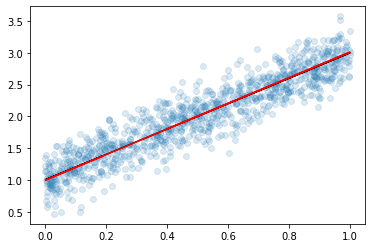

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# Seed random numbers for reproducibility
seed = 1
key = jax.random.PRNGKey(seed)


# Generate some noisy data with the true parameters
w = 2.
b = 1.
σ = 0.25  # noise standard deviation
N = 1000  # number of samples

key, key_x, key_ε = jax.random.split(key, 3)
x = jax.random.uniform(key_x, (N,))
ε = σ*jax.random.normal(key_ε, (N,))
y = w*x + b + ε


# Define a squared loss function and compute its gradient
loss = lambda w, b, X, Y: jnp.mean((X*w + b - Y)**2)
grad_loss = jax.grad(loss, argnums=(0, 1))            # takes the same args as `loss`


# Do gradient descent on each data point once in order (i.e., a single epoch)
learning_rate = 0.1
key, key_w, key_b = jax.random.split(key, 3)
w_hat = jax.random.normal(key_w)
b_hat = jax.random.normal(key_b)

for i in tqdm(range(N)):
    gw, gb = grad_loss(w_hat, b_hat, x[i], y[i])
    w_hat -= learning_rate * gw
    b_hat -= learning_rate * gb

    
# Print true and estimated parameters, and visualize the fit of each
print('True parameters:      w = {:.2f}, b = {:.2f}'.format(w, b))
print('Estimated parameters: w = {:.2f}, b = {:.2f}'.format(w_hat, b_hat))

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.15)
ax.plot(x, w*x + b, 'k')
ax.plot(x, w_hat*x + b_hat, 'r')
plt.show()

# Something a Bit More Complex

In [2]:
# Seed random numbers for reproducibility
seed = 1
key = jax.random.PRNGKey(seed)


# Define a more complicated underlying function
def f(x):
    y = 2./(1. + jnp.exp(-x**2)) + 0.25*jnp.cos(x)
    return y


# Generate some noisy data
σ = 0.1   # noise standard deviation
N = 1000  # number of samples

key, key_x, key_ε = jax.random.split(key, 3)
x = jax.random.uniform(key_x, (N,), minval=-5., maxval=5.)
ε = σ*jax.random.normal(key_ε, (N,))
y = f(x) + ε


# Define estimator as a neural network
def f_hat(x, θ):
    Ws, bs = θ['W'], θ['b']
    y = Ws[0]*x + bs[0]  # assumes `x` is a scalar
    for (W, b) in zip(Ws[1:], bs[1:]):
        y = W@jax.nn.relu(y) + b
    return y


# Define loss function and gradient
loss = lambda θ, X, Y: jnp.mean((Y - jax.vmap(f_hat, in_axes=(0, None))(X, θ))**2)
grad_loss = jax.jit(jax.grad(loss, argnums=0))  # args like `loss`, outputs like `θ`
loss = jax.jit(loss)


# Initialize neural network parameters
hidden_dims = [32, 32]
key, *keys_W = jax.random.split(key, len(hidden_dims) + 2)
key, *keys_b = jax.random.split(key, len(hidden_dims) + 2)
θ = {
    'W': [
        0.1*jax.random.normal(keys_W[0], (hidden_dims[0],)),
        0.1*jax.random.normal(keys_W[1], (hidden_dims[1], hidden_dims[0])),
        0.1*jax.random.normal(keys_W[2], (hidden_dims[1],)),
    ],
    'b': [
        0.1*jax.random.normal(keys_b[0], (hidden_dims[0],)),
        0.1*jax.random.normal(keys_b[1], (hidden_dims[1],)),
        0.1*jax.random.normal(keys_b[2]),
    ],
}


# Initialize gradient-based optimizer
learning_rate = 1e-3
init_opt, update_opt, get_params = optimizers.adam(learning_rate)
opt_state = init_opt(θ)
idx = 0

@jax.jit
def training_step(idx, opt_state, X, Y):
    θ = get_params(opt_state)
    grads = grad_loss(θ, X, Y)
    opt_state = update_opt(idx, grads, opt_state)
    return opt_state

  0%|          | 0/100 [00:00<?, ?it/s]

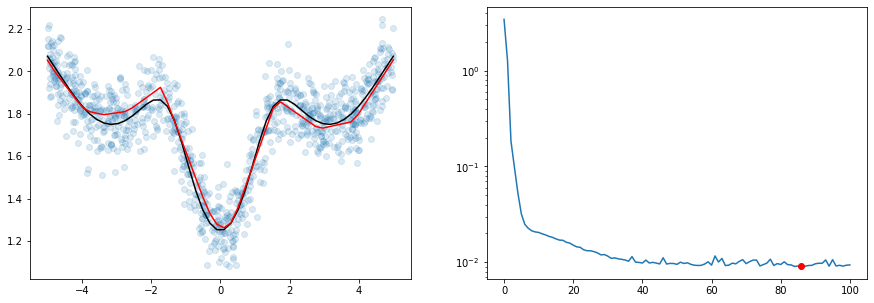

In [3]:
# Do batch stochastic gradient descent
batch = 20
epochs = 100
loss_values = jnp.zeros(epochs + 1)
loss_values = loss_values.at[0].set(loss(θ, x, y))

for i in tqdm(range(epochs)):
    # Shuffle the data
    key, key_shuffle = jax.random.split(key, 2)
    x_shuffled = jax.random.permutation(key_shuffle, x)
    y_shuffled = jax.random.permutation(key_shuffle, y)  # re-use the random key
    
    # Do batch gradient descent
    k = 0
    while k < N:
        # Sample
        x_batch = x_shuffled[k:k+batch]
        y_batch = y_shuffled[k:k+batch]
        k += batch
        
        # Gradient step
        opt_state = training_step(idx, opt_state, x_batch, y_batch)
        idx += 1
        
    # Record loss on all data at the end of the epoch
    θ = get_params(opt_state)
    loss_values = loss_values.at[i+1].set(loss(θ, x, y))


# Visualize fit and loss curve
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].scatter(x, y, alpha=0.15)
x_plt = jnp.linspace(-5, 5)
ax[0].plot(x_plt, f(x_plt), 'k')
ax[0].plot(x_plt, jax.vmap(f_hat, in_axes=(0, None))(x_plt, θ), 'r')
ax[1].semilogy(loss_values)
idx_min = loss_values.argmin()
ax[1].semilogy(idx_min, loss_values[idx_min], 'or')
plt.show()

# Modular Models in JAX via Equinox (https://docs.kidger.site/equinox/)

Instead of carrying around parameters everywhere, we'd like to be able to code something like
$$
    \ell(f_\theta, x, y) = \frac{1}{2}\lVert y - f_\theta(x) \rVert_2^2,
$$
and compute "gradients with respect to the function" $f_\theta$ (i.e., gradients with respect to the underlying parameters $\theta$ defining how $f_\theta$ operates on an input $x$).

In [4]:
import equinox as eqx

    
class FeedForwardNetwork(eqx.Module):
    Ws: list[jnp.ndarray]
    bs: list[jnp.ndarray]
    
    def __init__(self, key: jnp.ndarray, dims: tuple[int]):
        assert len(dims) >= 2
        keys_layers = jax.random.split(key, len(dims) - 1)
        
        self.Ws = []
        self.bs = []
        for i, key in enumerate(keys_layers):
            key_W, key_b = jax.random.split(key, 2)
            self.Ws.append(0.1*jax.random.normal(key_W, (dims[i+1], dims[i])))
            self.bs.append(0.1*jax.random.normal(key_b, (dims[i+1],)))
     
    def __call__(self, x):
        y = jnp.atleast_1d(x)
        for (W, b) in zip(self.Ws[:-1], self.bs[:-1]):
            y = jax.nn.relu(W@y + b)
        y = jnp.squeeze(self.Ws[-1]@y + self.bs[-1])
        return y
    

# A cleaner version using Equinox modules as "sub-modules", i.e., data members

# class FeedForwardNetwork(eqx.Module):
#     layers: list[eqx.Module]
    
#     def __init__(self, key: jnp.ndarray, dims: tuple[int]):
#         assert len(dims) >= 2
#         keys_layers = jax.random.split(key, len(dims) - 1)
#         self.layers = [eqx.nn.Linear(dims[i], dims[i+1], key=key) 
#                        for i, key in enumerate(keys_layers)]
     
#     def __call__(self, x):
#         y = jnp.atleast_1d(x)
#         for layer in self.layers[:-1]:
#             y = jax.nn.relu(layer(y))
#         y = jnp.squeeze(self.layers[-1](y))
#         return y
    

# Seed random numbers for reproducibility
seed = 2
key = jax.random.PRNGKey(seed)


# Define a more complicated underlying function
def f(x):
    y = 2./(1. + jnp.exp(-x**2)) + 0.25*jnp.cos(x)
    return y


# Generate some noisy data
σ = 0.1   # noise standard deviation
N = 1000  # number of samples

key, key_x, key_ε = jax.random.split(key, 3)
x = jax.random.uniform(key_x, (N,), minval=-5., maxval=5.)
ε = σ*jax.random.normal(key_ε, (N,))
y = f(x) + ε


# Define estimator as a neural network (class handles parameter initialization)
key, key_f = jax.random.split(key, 2)
f_hat = FeedForwardNetwork(key_f, (1, 32, 32, 1))
    

# Define loss function and gradient
loss = lambda f, X, Y: jnp.mean(jnp.abs(Y - jax.vmap(f)(X)))
grad_loss = jax.jit(jax.grad(loss, argnums=0))  # args like `loss`, outputs like `θ`
loss = jax.jit(loss)


# Initialize gradient-based optimizer
learning_rate = 1e-3
init_opt, update_opt, get_params = optimizers.adam(learning_rate)
opt_state = init_opt(f_hat)
idx = 0

@jax.jit
def training_step(idx, opt_state, X, Y):
    f_hat = get_params(opt_state)
    grads = grad_loss(f_hat, X, Y)
    opt_state = update_opt(idx, grads, opt_state)
    return opt_state

  0%|          | 0/100 [00:00<?, ?it/s]

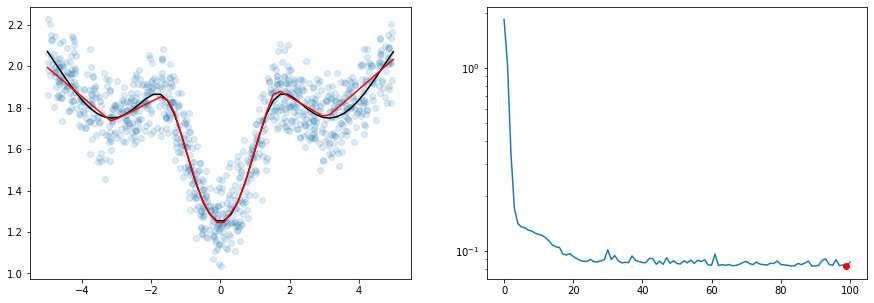

In [5]:
# Do batch stochastic gradient descent
batch = 20
epochs = 100
loss_values = jnp.zeros(epochs + 1)
loss_values = loss_values.at[0].set(loss(f_hat, x, y))

for i in tqdm(range(epochs)):
    # Shuffle the data
    key, key_shuffle = jax.random.split(key, 2)
    x_shuffled = jax.random.permutation(key_shuffle, x)
    y_shuffled = jax.random.permutation(key_shuffle, y)  # re-use the random key
    
    # Do batch gradient descent
    k = 0
    while k < N:
        # Sample
        x_batch = x_shuffled[k:k+batch]
        y_batch = y_shuffled[k:k+batch]
        k += batch
        
        # Gradient step
        opt_state = training_step(idx, opt_state, x_batch, y_batch)
        idx += 1
        
    # Record loss on all data at the end of the epoch
    f_hat_proposed = get_params(opt_state)
    loss_values = loss_values.at[i+1].set(loss(f_hat_proposed, x, y))
    if loss_values[i+1] < loss_values[i]:
        f_hat = f_hat_proposed


# Visualize fit and loss curve
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].scatter(x, y, alpha=0.15)
x_plt = jnp.linspace(-5, 5)
ax[0].plot(x_plt, f(x_plt), 'k')
ax[0].plot(x_plt, jax.vmap(f_hat)(x_plt), 'r')
ax[1].semilogy(loss_values)
idx_min = loss_values.argmin()
ax[1].semilogy(idx_min, loss_values[idx_min], 'or')
plt.show()